# PySpark

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
from pyspark.sql.functions import UserDefinedFunction,isnan, when, count, col, isnull,month, hour,year,minute,second,lower,lit,dayofweek, to_timestamp, to_date, monotonically_increasing_id, row_number
from pyspark.sql.types import TimestampType, DateType,DoubleType,FloatType,IntegerType, StringType, StructType, StructField
from pyspark.sql import DataFrame
from functools import reduce
from pyspark.sql import functions as F
import pandas as pd
import sparkpickle
import timeit
from sklearn.metrics import confusion_matrix
from pyspark.sql.functions import to_date, udf
import dateparser
import json
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import HashingTF, Tokenizer
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sc = SparkContext("local[*]", "Random Forest Models")
spark = SparkSession(sc)

# Filtered and preprocessed data

In [8]:
board_count_route4_dir1_stop12 = spark.read.csv('Data_for_RF_Models/Board_Counts/route_4/direction1/bus_stop_12/data.csv', header = True, inferSchema = True)
#board_count_route4_dir1_stop12 = pickle.load('Data_rf/board_count/direction1/route4/board_count_route4_dir1_stop12.pkl', header = True, inferSchema = True)

In [4]:
board_count_route4_dir1_stop12.show(5)

+---+-----+------------+----+-----------+--------------------+-------------------+-------------------------+-----------------------+
|_c0|month|service_kind|hour|board_count|           mean_temp|        mean_precip|month_average_board_count|surrounding_board_count|
+---+-----+------------+----+-----------+--------------------+-------------------+-------------------------+-----------------------+
|  0|    1|     weekday|   9|          0| 0.03389830508474576|0.02448210922787194|        5.559446327683614|     0.6160409556313993|
|  1|    1|     weekday|  10|          1|                0.05|0.05777777777777778|        7.511078518518519|     0.6628744785741373|
|  2|    1|     weekday|  13|          0|0.024509803921568627|0.04139433551198257|       10.161692810457515|     0.7853621539628365|
|  3|    1|     weekday|  14|          0| 0.03865979381443299|0.10309278350515465|       10.629673539518901|     0.8134133006395176|
|  4|    1|     weekday|  15|          0|0.047872340425531915|0.09456

In [5]:
board_count_route4_dir1_stop12 = board_count_route4_dir1_stop12.withColumnRenamed('_c0', 'index')
board_count_route4_dir1_stop12 = board_count_route4_dir1_stop12.withColumnRenamed('board_count', 'label')

In [6]:
board_count_route4_dir1_stop12.printSchema()

root
 |-- index: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- service_kind: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- mean_temp: double (nullable = true)
 |-- mean_precip: double (nullable = true)
 |-- month_average_board_count: double (nullable = true)
 |-- surrounding_board_count: double (nullable = true)



In [7]:
print(board_count_route4_dir1_stop12.count(), len(board_count_route4_dir1_stop12.columns))

1397 9


In [8]:
month_ind = StringIndexer().setInputCol('month').setOutputCol('Months')
hour_ind = StringIndexer().setInputCol('hour').setOutputCol('Hours')
serv_ind = StringIndexer().setInputCol('service_kind').setOutputCol('Serv_kinds')

In [9]:
board_count_route4_dir1_stop12 = month_ind.fit(board_count_route4_dir1_stop12).transform(board_count_route4_dir1_stop12)
board_count_route4_dir1_stop12 = hour_ind.fit(board_count_route4_dir1_stop12).transform(board_count_route4_dir1_stop12)
board_count_route4_dir1_stop12 = serv_ind.fit(board_count_route4_dir1_stop12).transform(board_count_route4_dir1_stop12)

In [10]:
board_count_route4_dir1_stop12 = board_count_route4_dir1_stop12.drop('month')
board_count_route4_dir1_stop12 = board_count_route4_dir1_stop12.drop('hour')
board_count_route4_dir1_stop12 = board_count_route4_dir1_stop12.drop('service_kind')

In [11]:
board_count_route4_dir1_stop12.show(5)

+-----+-----+--------------------+-------------------+-------------------------+-----------------------+------+-----+----------+
|index|label|           mean_temp|        mean_precip|month_average_board_count|surrounding_board_count|Months|Hours|Serv_kinds|
+-----+-----+--------------------+-------------------+-------------------------+-----------------------+------+-----+----------+
|    0|    0| 0.03389830508474576|0.02448210922787194|        5.559446327683614|     0.6160409556313993|   1.0| 10.0|       0.0|
|    1|    1|                0.05|0.05777777777777778|        7.511078518518519|     0.6628744785741373|   1.0|  3.0|       0.0|
|    2|    0|0.024509803921568627|0.04139433551198257|       10.161692810457515|     0.7853621539628365|   1.0|  2.0|       0.0|
|    3|    0| 0.03865979381443299|0.10309278350515465|       10.629673539518901|     0.8134133006395176|   1.0|  0.0|       0.0|
|    4|    0|0.047872340425531915|0.09456264775413711|        9.761633569739953|     0.7193899317

In [12]:
board_count_route4_dir1_stop12.printSchema()

root
 |-- index: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- mean_temp: double (nullable = true)
 |-- mean_precip: double (nullable = true)
 |-- month_average_board_count: double (nullable = true)
 |-- surrounding_board_count: double (nullable = true)
 |-- Months: double (nullable = false)
 |-- Hours: double (nullable = false)
 |-- Serv_kinds: double (nullable = false)



## Encoding Categorical Variables

In [13]:
encoder = OneHotEncoder(inputCols = ['Months', 'Hours', 'Serv_kinds'], outputCols = ['Months_Cat', 'Hours_Cat', 'Serv_kinds_Cat'])

In [14]:
model = encoder.fit(board_count_route4_dir1_stop12)
dt = model.transform(board_count_route4_dir1_stop12)
dt = dt.drop('Months')
dt = dt.drop('Hours')
dt = dt.drop('Serv_kinds')
dt.show(5)

+-----+-----+--------------------+-------------------+-------------------------+-----------------------+--------------+---------------+--------------+
|index|label|           mean_temp|        mean_precip|month_average_board_count|surrounding_board_count|    Months_Cat|      Hours_Cat|Serv_kinds_Cat|
+-----+-----+--------------------+-------------------+-------------------------+-----------------------+--------------+---------------+--------------+
|    0|    0| 0.03389830508474576|0.02448210922787194|        5.559446327683614|     0.6160409556313993|(11,[1],[1.0])|(17,[10],[1.0])| (1,[0],[1.0])|
|    1|    1|                0.05|0.05777777777777778|        7.511078518518519|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|
|    2|    0|0.024509803921568627|0.04139433551198257|       10.161692810457515|     0.7853621539628365|(11,[1],[1.0])| (17,[2],[1.0])| (1,[0],[1.0])|
|    3|    0| 0.03865979381443299|0.10309278350515465|       10.629673539518901|     0.8134133

## Random Partition into Training and Test Sets

In [15]:
(trainingData, ValidationSet) = dt.randomSplit([0.8, 0.2], seed = 123)

In [16]:
trainingData.show()

+-----+-----+--------------------+--------------------+-------------------------+-----------------------+--------------+---------------+--------------+
|index|label|           mean_temp|         mean_precip|month_average_board_count|surrounding_board_count|    Months_Cat|      Hours_Cat|Serv_kinds_Cat|
+-----+-----+--------------------+--------------------+-------------------------+-----------------------+--------------+---------------+--------------+
|    0|    0| 0.03389830508474576| 0.02448210922787194|        5.559446327683614|     0.6160409556313993|(11,[1],[1.0])|(17,[10],[1.0])| (1,[0],[1.0])|
|    1|    1|                0.05| 0.05777777777777778|        7.511078518518519|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|
|    3|    0| 0.03865979381443299| 0.10309278350515465|       10.629673539518901|     0.8134133006395176|(11,[1],[1.0])| (17,[0],[1.0])| (1,[0],[1.0])|
|    4|    0|0.047872340425531915| 0.09456264775413711|        9.761633569739953|     0.

In [17]:
ValidationSet.show()

+-----+-----+--------------------+--------------------+-------------------------+-----------------------+--------------+---------------+--------------+
|index|label|           mean_temp|         mean_precip|month_average_board_count|surrounding_board_count|    Months_Cat|      Hours_Cat|Serv_kinds_Cat|
+-----+-----+--------------------+--------------------+-------------------------+-----------------------+--------------+---------------+--------------+
|    2|    0|0.024509803921568627| 0.04139433551198257|       10.161692810457515|     0.7853621539628365|(11,[1],[1.0])| (17,[2],[1.0])| (1,[0],[1.0])|
|    6|    0|0.047872340425531915| 0.09456264775413711|        9.761633569739953|     0.7193899317406143|(11,[1],[1.0])| (17,[1],[1.0])| (1,[0],[1.0])|
|   12|    0|                0.05| 0.05777777777777778|        7.511078518518519|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|
|   13|    2|                0.05| 0.05777777777777778|        7.511078518518519|     0.

### Data for Classification

In [107]:
trainingData_clf = trainingData.withColumn('label', when(trainingData.label > 0, 1) \
                                           .otherwise(0))

In [108]:
label_ind = StringIndexer().setInputCol('label').setOutputCol('Label')

In [109]:
trainingData_clf = label_ind.fit(trainingData_clf).transform(trainingData_clf)

In [110]:
trainingData_clf = trainingData_clf.withColumnRenamed('Label', 'label')

In [63]:
#encoder = OneHotEncoder(inputCols = ['Label'], outputCols = ['Labels'])

In [93]:
#model_clf = encoder.fit(trainingData_clf)
#trainingData_clf = model_clf.transform(trainingData_clf)

In [68]:
#trainingData_clf = trainingData_clf.drop('Label')

In [111]:
trainingData_clf.show(5)

+-----+-----+--------------------+-------------------+-------------------------+-----------------------+--------------+---------------+--------------+
|index|label|           mean_temp|        mean_precip|month_average_board_count|surrounding_board_count|    Months_Cat|      Hours_Cat|Serv_kinds_Cat|
+-----+-----+--------------------+-------------------+-------------------------+-----------------------+--------------+---------------+--------------+
|    0|  0.0| 0.03389830508474576|0.02448210922787194|        5.559446327683614|     0.6160409556313993|(11,[1],[1.0])|(17,[10],[1.0])| (1,[0],[1.0])|
|    1|  1.0|                0.05|0.05777777777777778|        7.511078518518519|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|
|    3|  0.0| 0.03865979381443299|0.10309278350515465|       10.629673539518901|     0.8134133006395176|(11,[1],[1.0])| (17,[0],[1.0])| (1,[0],[1.0])|
|    4|  0.0|0.047872340425531915|0.09456264775413711|        9.761633569739953|     0.7193899

In [112]:
trainingData_clf.printSchema()

root
 |-- index: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- mean_temp: double (nullable = true)
 |-- mean_precip: double (nullable = true)
 |-- month_average_board_count: double (nullable = true)
 |-- surrounding_board_count: double (nullable = true)
 |-- Months_Cat: vector (nullable = true)
 |-- Hours_Cat: vector (nullable = true)
 |-- Serv_kinds_Cat: vector (nullable = true)



### Data for Regression

In [20]:
trainingData_reg = trainingData.filter(trainingData.label > 0)

In [58]:
trainingData_reg.printSchema()

root
 |-- index: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- mean_temp: double (nullable = true)
 |-- mean_precip: double (nullable = true)
 |-- month_average_board_count: double (nullable = true)
 |-- surrounding_board_count: double (nullable = true)
 |-- Months_Cat: vector (nullable = true)
 |-- Hours_Cat: vector (nullable = true)
 |-- Serv_kinds_Cat: vector (nullable = true)



In [21]:
trainingData_reg.show()

+-----+-----+--------------------+-------------------+-------------------------+-----------------------+--------------+---------------+--------------+
|index|label|           mean_temp|        mean_precip|month_average_board_count|surrounding_board_count|    Months_Cat|      Hours_Cat|Serv_kinds_Cat|
+-----+-----+--------------------+-------------------+-------------------------+-----------------------+--------------+---------------+--------------+
|    1|    1|                0.05|0.05777777777777778|        7.511078518518519|     0.6628744785741373|(11,[1],[1.0])| (17,[3],[1.0])| (1,[0],[1.0])|
|    5|    1|0.047872340425531915|0.09456264775413711|        9.761633569739953|     0.7193899317406143|(11,[1],[1.0])| (17,[1],[1.0])| (1,[0],[1.0])|
|   14|    1|0.024509803921568627|0.04139433551198257|       10.161692810457515|     0.7853621539628365|(11,[1],[1.0])| (17,[2],[1.0])| (1,[0],[1.0])|
|   15|    1|0.047872340425531915|0.09456264775413711|        9.761633569739953|     0.7193899

In [22]:
#testData_reg = testData.filter(testData.label > 0)
#testData_reg2 = testData.toPandas()
#testData_reg2 = testData_reg2[testData_reg2['index'].isin(clf_predictions[clf_predictions['label_clf'] == 1].index.values)]
#testData_reg2.head()

In [23]:
#testData_reg2a = spark.createDataFrame(testData_reg2)

### Subordinate Functions

In [24]:
def paste0(ss,sep=None,na_rep=None,):
            '''Analogy to R paste0'''
            ss = [pd.Series(s) for s in ss]
            ss = [s.astype(str) for s in ss]
            s = ss[0]
            res = s.str.cat(ss[1:],sep=sep,na_rep=na_rep)
            return res

In [26]:
trainingData_clf.columns[1:9]

['label',
 'mean_temp',
 'mean_precip',
 'month_average_board_count',
 'surrounding_board_count',
 'Months_Cat',
 'Hours_Cat',
 'Serv_kinds_Cat']

# Classification by Random Forest

## Label and Features

In [113]:
feature_list = []
for col in trainingData_clf.columns[1:9]:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

In [114]:
assembler = VectorAssembler(inputCols = feature_list, outputCol = "features")

In [115]:
rf_clf = RandomForestClassifier(labelCol = "label", featuresCol = "features")

In [116]:
pipeline = Pipeline(stages=[assembler, rf_clf])

In [117]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf_clf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]) \
    .addGrid(rf_clf.maxDepth, [int(x) for x in np.linspace(start = 2, stop = 30, num = 6)]) \
    .build()

In [118]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [119]:
tic = timeit.default_timer()

cv_clf_Model = crossval.fit(trainingData_clf)

toc = timeit.default_timer()

processing_time_min = (toc - tic)/60

In [120]:
processing_time_min

14.322231098583325

In [40]:
cv_clf_Model.write().overwrite().save('RF_Models/Board_Counts/route_4/direction1/clf_bus_stop_12/')

## Model Tuning

In [121]:
# Feature importance
bestPipeline_clf = cv_clf_Model.bestModel
bestModel_clf = bestPipeline_clf.stages[1]


# Best hyperparameters
print('numTrees - ', bestModel_clf.getNumTrees)
print('maxDepth - ', bestModel_clf.getOrDefault('maxDepth'))

numTrees -  100
maxDepth -  2


In [122]:
feature_list

['mean_temp',
 'mean_precip',
 'month_average_board_count',
 'surrounding_board_count',
 'Months_Cat',
 'Hours_Cat',
 'Serv_kinds_Cat']

Text(0.5, 1.0, 'Feature Importances')

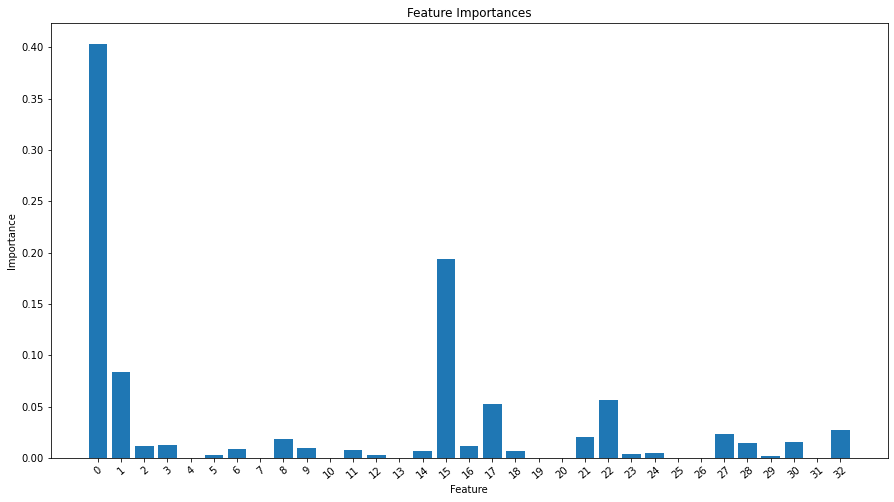

In [123]:
# Feature importance
bestPipeline_clf = cv_clf_Model.bestModel
bestModel_clf = bestPipeline_clf.stages[1]

importances_clf = bestModel_clf.featureImportances

x_values = list(range(len(importances_clf)))
plt.figure(figsize = (15,8))

plt.bar(x_values, importances_clf, orientation = 'vertical')
plt.xticks(x_values, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

# Regression by Random Forest

## Training Data for Regression

In [124]:
feature_list_reg = []
for col in trainingData_reg.columns[1:9]:
    if col == 'label':
        continue
    else:
        feature_list_reg.append(col)

In [125]:
assembler_reg = VectorAssembler(inputCols = feature_list_reg, outputCol = "features")

In [126]:
rf_reg = RandomForestRegressor(labelCol="label", featuresCol="features")

In [127]:
pipeline_reg = Pipeline(stages=[assembler_reg, rf_reg])

In [128]:
#ParamGrid = ParamGridBuilder() \
#    .addGrid(rf_reg.numTrees, [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]) \
#    .addGrid(rf_reg.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 30, num = 6)]) \
#    .build()

In [129]:
crossval_reg = CrossValidator(estimator=pipeline_reg,
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(),
                              numFolds=5)

In [130]:
tic = timeit.default_timer()

cv_reg_Model = crossval_reg.fit(trainingData_reg)

toc = timeit.default_timer()

processing2_time_min = (toc - tic)/60

In [131]:
processing2_time_min

2.4079042615500232

# Combining the two models

In [132]:
predictions_clf = cv_clf_Model.transform(ValidationSet)

In [133]:
clf_predictions = predictions_clf[['index', 'label', 'prediction']].toPandas()
clf_predictions.columns = ['index', 'board_count', 'prediction_clf']
clf_predictions.head()

,index,board_count,prediction_clf
0,2,0,0.0
1,6,0,0.0
2,12,0,0.0
3,13,2,0.0
4,18,3,0.0


In [134]:
clf_predictions[clf_predictions['prediction_clf'] == 1]

,index,board_count,prediction_clf
11,38,1,1.0
15,61,1,1.0
39,198,0,1.0
47,219,0,1.0
56,267,1,1.0
62,292,0,1.0
65,300,5,1.0
68,317,3,1.0
94,471,0,1.0
112,549,2,1.0


#### Extract predicted counts for regression:

In [174]:
index_reg = clf_predictions[clf_predictions['prediction_clf'] == 1]['index'].values
ValidationSet_pd = ValidationSet.toPandas()

In [175]:
ValidationSet_pd.head()

,index,label,mean_temp,mean_precip,month_average_board_count,surrounding_board_count,Months_Cat,Hours_Cat,Serv_kinds_Cat
0,2,0,0.024510,0.041394,10.161693,0.785362,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(1.0)
1,6,0,0.047872,0.094563,9.761634,0.719390,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(1.0)
2,12,0,0.050000,0.057778,7.511079,0.662874,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(1.0)
3,13,2,0.050000,0.057778,7.511079,0.662874,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(1.0)
4,18,3,0.050000,0.057778,7.511079,0.662874,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(1.0)


In [176]:
ValidationSet_pd.shape

(285, 9)

In [177]:
ValidationData_reg = ValidationSet_pd[ValidationSet_pd['index'].isin(index_reg)]

In [178]:
ValidationData_reg.head()

,index,label,mean_temp,mean_precip,month_average_board_count,surrounding_board_count,Months_Cat,Hours_Cat,Serv_kinds_Cat
11,38,1,0.210938,0.038194,10.294859,0.588684,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(0.0)
15,61,1,0.210938,0.038194,10.294859,0.588684,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(0.0)
39,198,0,0.181034,0.168582,10.444680,0.668942,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(0.0)
47,219,0,0.285714,0.099206,16.404030,0.713311,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(0.0)
56,267,1,0.285714,0.099206,16.404030,0.713311,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",(0.0)


##### Prepare data for regression: 'From Pandas back to pyspark'

In [179]:
ValidationSet2 = spark.createDataFrame(ValidationData_reg)

##### Predict counts:

In [180]:
predictions_reg = cv_reg_Model.transform(ValidationSet2)
predictions_reg_data = predictions_reg[['index', 'prediction', 'label']].toPandas()
predictions_reg_data.columns = ['index', 'prediction_reg', 'label_reg']

In [181]:
predictions_reg_data.head()

,index,prediction_reg,label_reg
0,38,2.374046,1
1,61,2.374046,1
2,198,2.314070,0
3,219,2.605787,0
4,267,2.605787,1


## Combine predictions:

In [182]:
Predictions = pd.merge(clf_predictions, predictions_reg_data, on = 'index', how = 'left')
Predictions.head()

,index,board_count,prediction_clf,prediction_reg,label_reg
0,2,0,0.0,NaN,NaN
1,6,0,0.0,NaN,NaN
2,12,0,0.0,NaN,NaN
3,13,2,0.0,NaN,NaN
4,18,3,0.0,NaN,NaN


In [183]:
Predictions[Predictions['prediction_clf'] == 1]

,index,board_count,prediction_clf,prediction_reg,label_reg
11,38,1,1.0,2.374046,1.0
15,61,1,1.0,2.374046,1.0
39,198,0,1.0,2.314070,0.0
47,219,0,1.0,2.605787,0.0
56,267,1,1.0,2.605787,1.0
62,292,0,1.0,2.605787,0.0
65,300,5,1.0,2.605787,5.0
68,317,3,1.0,2.605787,3.0
94,471,0,1.0,3.362897,0.0
112,549,2,1.0,3.362897,2.0


In [184]:
Predictions['Predictions'] = np.where(Predictions['prediction_clf'] == 1, Predictions['prediction_reg'], 0)

In [4]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
sns.set(rc={'figure.figsize':(13,8.27)})

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


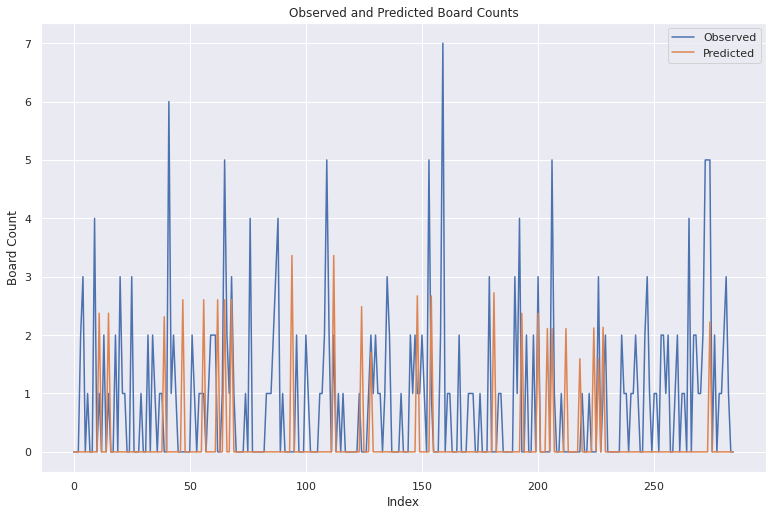

In [204]:
sns.set_theme(style="darkgrid")
plt.title('Observed and Predicted Board Counts')
fig.suptitle('Predicted versus actual counts using a Random Forest Pipeline')
sns.lineplot(Predictions.index, Predictions.board_count, label='Observed', data = Predictions)
sns.lineplot(Predictions.index, Predictions.Predictions, label='Predicted', data = Predictions)
plt.xlabel("Index")
plt.ylabel("Board Count")
plt.legend()

Text(0.5, 1.0, 'Feature Importances')

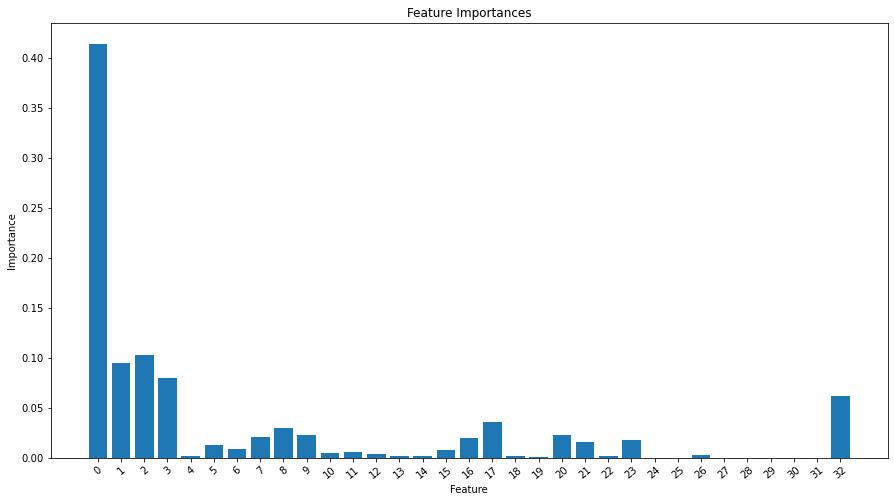

In [143]:
# Feature importance
bestPipeline_reg = cv_reg_Model.bestModel
bestModel_reg = bestPipeline_reg.stages[1]

importances_reg = bestModel_reg.featureImportances

x_values = list(range(len(importances_reg)))
plt.figure(figsize = (15,8))

plt.bar(x_values, importances_reg, orientation = 'vertical')
plt.xticks(x_values, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [144]:
# Best hyperparameters
print('numTrees - ', bestModel_reg.getNumTrees)
print('maxDepth - ', bestModel_reg.getOrDefault('maxDepth'))

numTrees -  20
maxDepth -  5


# Complete function

In [11]:
def rand_forest_pipeline(DF, route, direction, bus_stop):
    
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
    from pyspark.ml.regression import RandomForestRegressor
    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    from pyspark.mllib.evaluation import BinaryClassificationMetrics
    from pyspark.sql import DataFrame
    
    DF = DF.withColumnRenamed('_c0', 'index')
    DF = DF.withColumnRenamed('board_count', 'label')
       
    month_ind = StringIndexer().setInputCol('month').setOutputCol('Months')
    hour_ind = StringIndexer().setInputCol('hour').setOutputCol('Hours')
    serv_ind = StringIndexer().setInputCol('service_kind').setOutputCol('Serv_kinds')
    
    DF = month_ind.fit(DF).transform(DF)
    DF = hour_ind.fit(DF).transform(DF)
    DF = serv_ind.fit(DF).transform(DF)
    
    DF = DF.drop('month')
    DF = DF.drop('hour')
    DF = DF.drop('service_kind')
    
    encoder = OneHotEncoder(inputCols = ['Months', 'Hours', 'Serv_kinds'], outputCols = ['Months_Cat', 'Hours_Cat', 'Serv_kinds_Cat'])
    model = encoder.fit(DF)
    dt = model.transform(DF)
    dt = dt.drop('Months')
    dt = dt.drop('Hours')
    dt = dt.drop('Serv_kinds')
        
    (trainingData, ValidationSet) = dt.randomSplit([0.8, 0.2], seed = 123)
             
    #-------------------------------------------------------------------------------------------------------------
    # Required function to save the models:
    
    def paste0(ss,sep=None,na_rep=None,):
            '''Analogy to R paste0'''
            ss = [pd.Series(s) for s in ss]
            ss = [s.astype(str) for s in ss]
            s = ss[0]
            res = s.str.cat(ss[1:],sep=sep,na_rep=na_rep)
            return res
    
    
    file_path = paste0([paste0([paste0(['RF_Models', 'Board_Counts'], sep ='/'), 
                                    paste0(['route', route], sep = '_')], sep = '/'), 
                            paste0([paste0(['direction', direction]),
                                    paste0(['bus_stop', bus_stop], sep = '_')], sep = '/')], sep = '/')
    
    file_name_clf = paste0(['clf', 'model'], sep = '_')
    file_name_reg = paste0(['reg', 'model'], sep = '_')
    
    complete_path_clf = paste0([file_path, file_name_clf], sep = '/')[0]
    complete_path_reg = paste0([file_path, file_name_reg], sep = '/')[0]
    #-------------------------------------------------------------------------------------------------------------
    # Classification
    
    ## Data preparation:
    
    trainingData_clf = trainingData.withColumn('label', when(trainingData.label > 0, 1) \
                                               .otherwise(0))
       
    feature_list = []
    for col in trainingData_clf.columns:
        if col == 'label':
            continue
        else:
            feature_list.append(col)
            
            
    assembler = VectorAssembler(inputCols=feature_list, outputCol="features")
    
    ## Random Forest Classifier:
    
    rf_clf = RandomForestClassifier(labelCol="label", featuresCol="features")
    
    pipeline = Pipeline(stages=[assembler, rf_clf])
    
    paramGrid = ParamGridBuilder() \
        .addGrid(rf_clf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]) \
        .addGrid(rf_clf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 6)]) \
        .build()
    
    crossval = CrossValidator(estimator = pipeline,
                              estimatorParamMaps = paramGrid,
                              evaluator = BinaryClassificationEvaluator(),
                              numFolds = 5)
    
    ### Train Model:
    
    cv_clf_Model = crossval.fit(trainingData_clf)
    
    #### Save trained model:
    cv_clf_Model.write().overwrite().save(complete_path_clf)
    
    #--------------------------------------------------------------------------------------------------
    # Regression
    
    ## Data preparation:
    
    trainingData_reg = spark.createDataFrame(trainingData.filter(trainingData.label > 0).collect())
        
    feature_list_reg = []
    for col in trainingData_reg.columns[1:8]:
        if col == 'label':
            continue
        else:
            feature_list_reg.append(col)
            
    assembler_reg = VectorAssembler(inputCols = feature_list_reg, outputCol = "features")
        
    ## Random Forest Regression:
    
    rf_reg = RandomForestRegressor(labelCol="label", featuresCol="features")
    pipeline_reg = Pipeline(stages=[assembler_reg, rf_reg])
    
    paramGrid = ParamGridBuilder() \
        .addGrid(rf_reg.numTrees, [int(x) for x in np.linspace(start = 10, stop = 100, num = 3)]) \
        .addGrid(rf_reg.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 5)]) \
        .build()
    
    crossval_reg = CrossValidator(estimator=pipeline_reg,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=RegressionEvaluator(),
                                  numFolds=5)
    ### Train Model:
    
    cv_reg_Model = crossval_reg.fit(trainingData_reg)
    
    #### Save trained model:
    cv_reg_Model.write().overwrite().save(complete_path_reg)
    
    #------------------------------------------------------------------------------------------------
    ### Test Combined Models:
    
    #### Classification:
    
       
    ##### Predict zeros and counts:
    
    clf_Model_predictions = cv_clf_Model.transform(ValidationSet)
    
    clf_predictions = clf_Model_predictions[['index', 'label', 'prediction']].toPandas()
    clf_predictions.columns = ['index', 'board_count', 'prediction_clf']
    
    #### Regression:
    
    ##### Extract predicted counts for regression:
    
    index_reg = clf_predictions[clf_predictions['prediction_clf'] == 1]['index'].values
    
    ValidationSet_pd = ValidationSet.toPandas()
    
    ValidationData_reg = ValidationSet_pd[ValidationSet_pd['index'].isin(index_reg)]
    
    ##### Prepare data for regression: 'From Pandas back to pyspark'
    
    ValidationSet2 = spark.createDataFrame(ValidationData_reg)
    
    ##### Predict counts:
    
    predictions_reg = cv_reg_Model.transform(ValidationSet2)
    
    predictions_reg_data = predictions_reg[['index', 'prediction', 'label']].toPandas()
    predictions_reg_data.columns = ['index', 'prediction_reg', 'label_reg']
    
    #------------------------------------------------------------------------------------------------------
    # Combine predictions:
    
    Predictions = pd.merge(clf_predictions, predictions_reg_data, on = 'index', how = 'left')
    Predictions['Predictions'] = np.where(Predictions['prediction_clf'] == 1, Predictions['prediction_reg'], 0)
                              
    return(Predictions)

# Route 4

## Direction 1

### Bus Stop 12

In [9]:
board_count_route4_dir1_stop12 = spark.read.csv('Data_for_RF_Models/Board_Counts/route_4/direction1/bus_stop_12/data.csv', header = True, inferSchema = True)

In [13]:
pred_route4_dir1_stop12 = rand_forest_pipeline(board_count_route4_dir1_stop12, '4', '1', '12')

In [15]:
pred_route4_dir1_stop12.head()

,index,board_count,prediction_clf,prediction_reg,label_reg,Predictions
0,2,0,0.0,NaN,NaN,0.0
1,6,0,0.0,NaN,NaN,0.0
2,12,0,0.0,NaN,NaN,0.0
3,13,2,0.0,NaN,NaN,0.0
4,18,3,0.0,NaN,NaN,0.0


In [37]:
np.sqrt(np.mean(pred_route4_dir1_stop12.board_count - pred_route4_dir1_stop12.Predictions)**2)

0.2795094699693219

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


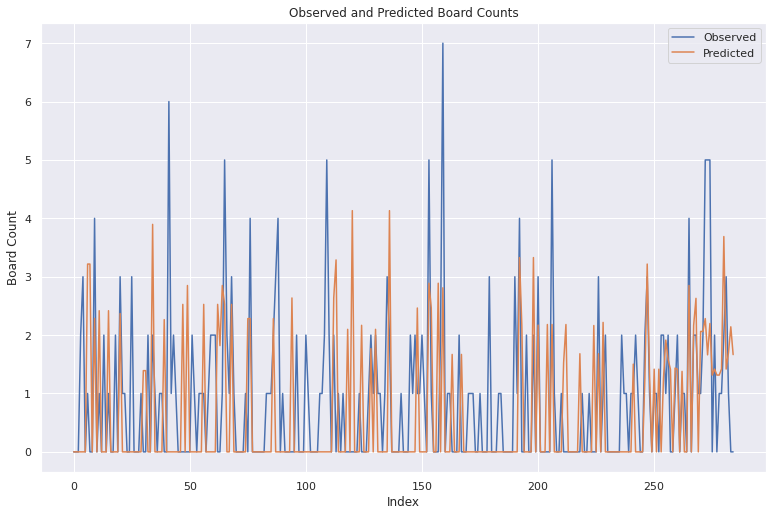

In [19]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")
plt.title('Observed and Predicted Board Counts')
sns.lineplot(pred_route4_dir1_stop12.index, pred_route4_dir1_stop12.board_count, label='Observed', data = pred_route4_dir1_stop12)
sns.lineplot(pred_route4_dir1_stop12.index, pred_route4_dir1_stop12.Predictions, label='Predicted', data = pred_route4_dir1_stop12)
plt.xlabel("Index")
plt.ylabel("Board Count")
plt.legend()

### Bus Stop 1351

In [20]:
board_count_route4_dir1_stop1351 = spark.read.csv('Data_for_RF_Models/Board_Counts/route_4/direction1/bus_stop_1351/data.csv', header = True, inferSchema = True)

In [21]:
board_count_route4_dir1_stop1351.show()

+---+-----+------------+----+-----------+--------------------+-------------------+-------------------------+-----------------------+
|_c0|month|service_kind|hour|board_count|           mean_temp|        mean_precip|month_average_board_count|surrounding_board_count|
+---+-----+------------+----+-----------+--------------------+-------------------+-------------------------+-----------------------+
|  0|    1|     weekday|   5|          0|                 0.0|0.31578947368421056|       3.1263157894736846|     0.6360876392731623|
|  1|    1|     weekday|   6|          0|                 0.0|0.07407407407407407|        4.999074074074072|     0.5613978676595025|
|  2|    1|     weekday|   6|          0|                 0.0|0.07407407407407407|        4.999074074074072|     0.5613978676595025|
|  3|    1|     weekday|   7|          0|0.048665620094191515| 0.0575139146567718|        4.946938775510202|     0.6586620657203356|
|  4|    1|     weekday|   8|          0|                 0.0|0.05896

In [22]:
pred_route4_dir1_stop1351 = rand_forest_pipeline(board_count_route4_dir1_stop1351, '4', '1', '1351')

In [23]:
pred_route4_dir1_stop1351.head()

,index,board_count,prediction_clf,prediction_reg,label_reg,Predictions
0,2,0,0.0,NaN,NaN,0.0
1,6,0,0.0,NaN,NaN,0.0
2,12,0,0.0,NaN,NaN,0.0
3,13,0,0.0,NaN,NaN,0.0
4,18,0,0.0,NaN,NaN,0.0


In [38]:
np.sqrt(np.mean(pred_route4_dir1_stop1351.board_count - pred_route4_dir1_stop1351.Predictions)**2)

0.39105497354649604

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


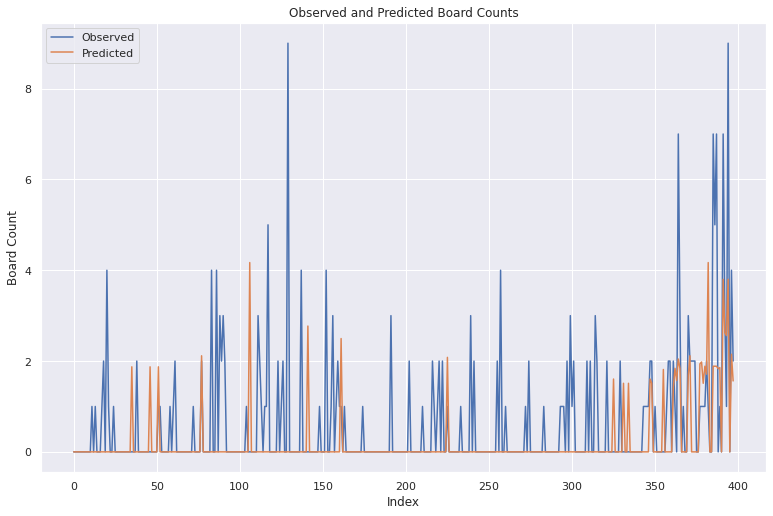

In [24]:
sns.set_theme(style="darkgrid")
plt.title('Observed and Predicted Board Counts')
sns.lineplot(pred_route4_dir1_stop1351.index, pred_route4_dir1_stop1351.board_count, label='Observed', data = pred_route4_dir1_stop1351)
sns.lineplot(pred_route4_dir1_stop1351.index, pred_route4_dir1_stop1351.Predictions, label='Predicted', data = pred_route4_dir1_stop1351)
plt.xlabel("Index")
plt.ylabel("Board Count")
plt.legend()

### Bus Stop 1883

In [25]:
board_count_route4_dir1_stop1883 = spark.read.csv('Data_for_RF_Models/Board_Counts/route_4/direction1/bus_stop_1883/data.csv', header = True, inferSchema = True)

In [29]:
board_count_route4_dir1_stop1883.show(10)

+---+-----+------------+----+-----------+-------------------+-------------------+-------------------------+-----------------------+
|_c0|month|service_kind|hour|board_count|          mean_temp|        mean_precip|month_average_board_count|surrounding_board_count|
+---+-----+------------+----+-----------+-------------------+-------------------+-------------------------+-----------------------+
|  0|    1|     weekday|   5|          0| 0.3057110862262038|                0.0|        4.808918128654971|     0.5599272821711466|
|  1|    1|     weekday|   6|          2|0.28610763454317895|0.07058823529411765|        5.027647058823528|     0.4759381898454747|
|  2|    1|     weekday|   6|          1|0.28610763454317895|0.07058823529411765|        5.027647058823528|     0.4759381898454747|
|  3|    1|     weekday|   6|          1|0.28610763454317895|0.07058823529411765|        5.027647058823528|     0.4759381898454747|
|  4|    1|     weekday|   7|          5|0.30180388529139685|               

In [39]:
np.sqrt(np.mean(pred_route4_dir1_stop1883.board_count - pred_route4_dir1_stop1883.Predictions)**2)

0.680347762822981

In [26]:
pred_route4_dir1_stop1883 = rand_forest_pipeline(board_count_route4_dir1_stop1883, '4', '1', '1883')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


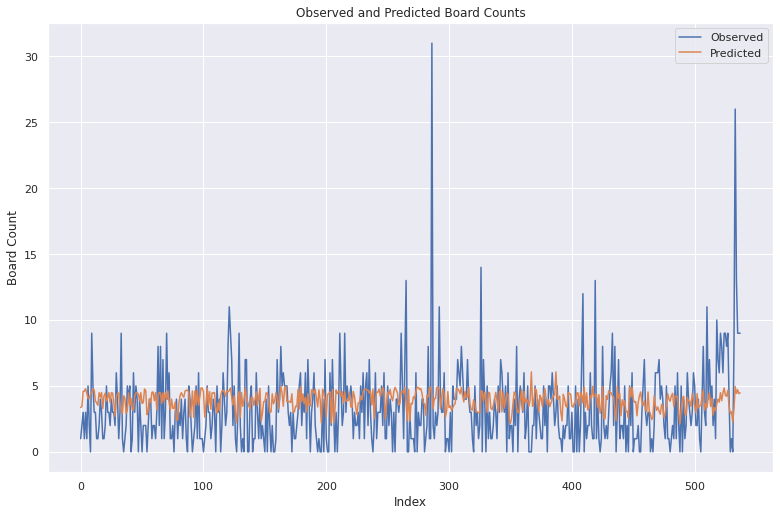

In [27]:
sns.set_theme(style="darkgrid")
plt.title('Observed and Predicted Board Counts')
sns.lineplot(pred_route4_dir1_stop1883.index, pred_route4_dir1_stop1883.board_count, label='Observed', data = pred_route4_dir1_stop1883)
sns.lineplot(pred_route4_dir1_stop1883.index, pred_route4_dir1_stop1883.Predictions, label='Predicted', data = pred_route4_dir1_stop1883)
plt.xlabel("Index")
plt.ylabel("Board Count")
plt.legend()

In [28]:
pred_route4_dir1_stop1883.head()

,index,board_count,prediction_clf,prediction_reg,label_reg,Predictions
0,2,1,1.0,3.364315,1,3.364315
1,6,2,1.0,3.447906,2,3.447906
2,12,3,1.0,4.600624,3,4.600624
3,13,1,1.0,4.600624,1,4.600624
4,18,3,1.0,4.788753,3,4.788753
